In [37]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
torch.__version__

'1.6.0'

In [3]:
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true


In [4]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [5]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [6]:
torch.cuda.device_count()

2

In [7]:
EPOCHS = 20
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = 1e-3 
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 2 Batch size: 128 Learning rate: 0.001


In [8]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [9]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [10]:
#data_diffr = np.load('../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
real_space = np.load('../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

In [11]:
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [12]:
try:
    data_diffr = np.load('../data/20191008_39_diff.npz')['arr_0']
    data_diffr_red = np.load('../data/20191008_39_diff_reduced.npz')['arr_0']
except:
    print(data_diffr.shape)
    #plt.matshow(np.log10(data_diffr[0,0]))

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])
    np.savez_compressed('../data/20191008_39_diff_reduced.npz', data_diffr_red)

  0%|          | 0/161 [00:00<?, ?it/s]

(161, 161, 256, 256)


100%|██████████| 161/161 [00:42<00:00,  3.79it/s]


In [13]:
data_diffr.shape, data_diffr_red.shape

((161, 161, 256, 256), (161, 161, 64, 64))

In [231]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=142)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [232]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [233]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [265]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [282]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1, 1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1, 1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv * 4, nconv * 2, 3, stride=1, padding=(1,1)),
          nn.ConvTranspose2d(nconv * 2, nconv*4, 3, stride=2, padding=(1,1), output_padding=(1,1)),
          nn.ReLU(),
          #nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv *2, nconv, 3, stride=1, padding=(1,1)),
          nn.ConvTranspose2d(nconv, nconv*2, 3, stride=2, padding=(1,1), output_padding=(1,1)),
          nn.ReLU(),
          #nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv * 2, nconv, 3, stride=1, padding=(1,1)),
          nn.ConvTranspose2d(nconv, nconv*2, 3, stride=2, padding=(1,1), output_padding=(1,1)),
          nn.ReLU(),
          #nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv * 4, nconv * 2, 3, stride=1, padding=(1,1)),
          nn.ConvTranspose2d(nconv * 2, nconv*4, 3, stride=2, padding=(1,1), output_padding=(1,1)),
          nn.ReLU(),
          #nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv *2, nconv, 3, stride=1, padding=(1,1)),
          nn.ConvTranspose2d(nconv, nconv*2, 3, stride=2, padding=(1,1), output_padding=(1,1)),
          nn.ReLU(),
          #nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv * 2, nconv, 3, stride=1, padding=(1,1)),
          nn.ConvTranspose2d(nconv, nconv*2, 3, stride=2, padding=(1,1), output_padding=(1,1)),
          nn.ReLU(),
          #nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [236]:
in_height, in_width = 8, 8
filter_height, filter_width = 3, 3
strides=(None,2,2)
out_height = np.ceil(float(in_height) / float(strides[1]))
out_width  = np.ceil(float(in_width) / float(strides[2]))

#The total padding applied along the height and width is computed as:

if (in_height % strides[1] == 0):
  pad_along_height = max(filter_height - strides[1], 0)
else:
  pad_along_height = max(filter_height - (in_height % strides[1]), 0)
if (in_width % strides[2] == 0):
  pad_along_width = max(filter_width - strides[2], 0)
else:
  pad_along_width = max(filter_width - (in_width % strides[2]), 0)

print(pad_along_height, pad_along_width)
  
#Finally, the padding on the top, bottom, left and right are:

pad_top = pad_along_height // 2
pad_bottom = pad_along_height - pad_top
pad_left = pad_along_width // 2
pad_right = pad_along_width - pad_left

print(pad_left, pad_right, pad_top, pad_bottom, out_height, out_width)

1 1
0 1 0 1 4.0 4.0


In [237]:
padding_deconv = 3 - 1 - 1
Hout = (8 - 1)  * 2 - 2 + 3 + padding_deconv
padding_deconv, Hout

(1, 16)

In [283]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp_train, ph_train = model(ft_images)
    print(amp_train.shape, ph_train.shape)
    print(amp_train.dtype, ph_train.dtype)
    break

batch size: torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64])
torch.float32 torch.float32


In [284]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 32, 64, 64]          320
|    └─ReLU: 2-2                         [-1, 32, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 32, 64, 64]          9,248
|    └─ReLU: 2-4                         [-1, 32, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 64, 32, 32]          18,496
|    └─ReLU: 2-7                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-8                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-9                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-10                   [-1, 64, 16, 16]          --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-12                        [-1, 128, 16, 16]         --

In [285]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()#
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR / 10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 720.0 which is every 6 epochs


In [286]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

**For the "mixed precision" part we just modify the original code slightly to include the 'scaler' in the following code blocks**

In [287]:
scaler = torch.cuda.amp.GradScaler()

In [288]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase
        
        
        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
           
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [289]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [290]:

for epoch in range (60):#EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

120it [00:16,  7.28it/s]


Saving improved model after Val Loss improved from inf to 0.88486
Epoch: 0 | FT  | Train Loss: 0.85910 | Val Loss: 0.88486
Epoch: 0 | Amp | Train Loss: 0.1298 | Val Loss: 0.1013
Epoch: 0 | Ph  | Train Loss: 0.729 | Val Loss: 0.784
Epoch: 0 | Ending LR: 0.000250 


120it [00:16,  7.37it/s]


Saving improved model after Val Loss improved from 0.88486 to 0.87803
Epoch: 1 | FT  | Train Loss: 0.76733 | Val Loss: 0.87803
Epoch: 1 | Amp | Train Loss: 0.0876 | Val Loss: 0.1012
Epoch: 1 | Ph  | Train Loss: 0.680 | Val Loss: 0.777
Epoch: 1 | Ending LR: 0.000400 


120it [00:16,  7.35it/s]


Epoch: 2 | FT  | Train Loss: 0.74287 | Val Loss: 0.90266
Epoch: 2 | Amp | Train Loss: 0.0890 | Val Loss: 0.1011
Epoch: 2 | Ph  | Train Loss: 0.654 | Val Loss: 0.802
Epoch: 2 | Ending LR: 0.000550 


120it [00:16,  7.37it/s]


Saving improved model after Val Loss improved from 0.87803 to 0.65663
Epoch: 3 | FT  | Train Loss: 0.65851 | Val Loss: 0.65663
Epoch: 3 | Amp | Train Loss: 0.0673 | Val Loss: 0.0273
Epoch: 3 | Ph  | Train Loss: 0.591 | Val Loss: 0.629
Epoch: 3 | Ending LR: 0.000700 


120it [00:16,  7.26it/s]


Saving improved model after Val Loss improved from 0.65663 to 0.52440
Epoch: 4 | FT  | Train Loss: 0.50908 | Val Loss: 0.52440
Epoch: 4 | Amp | Train Loss: 0.0137 | Val Loss: 0.0092
Epoch: 4 | Ph  | Train Loss: 0.495 | Val Loss: 0.515
Epoch: 4 | Ending LR: 0.000850 


120it [00:16,  7.35it/s]


Saving improved model after Val Loss improved from 0.52440 to 0.47097
Epoch: 5 | FT  | Train Loss: 0.42424 | Val Loss: 0.47097
Epoch: 5 | Amp | Train Loss: 0.0077 | Val Loss: 0.0084
Epoch: 5 | Ph  | Train Loss: 0.417 | Val Loss: 0.463
Epoch: 5 | Ending LR: 0.001000 


120it [00:16,  7.33it/s]


Saving improved model after Val Loss improved from 0.47097 to 0.41286
Epoch: 6 | FT  | Train Loss: 0.36672 | Val Loss: 0.41286
Epoch: 6 | Amp | Train Loss: 0.0072 | Val Loss: 0.0078
Epoch: 6 | Ph  | Train Loss: 0.359 | Val Loss: 0.405
Epoch: 6 | Ending LR: 0.000850 


120it [00:16,  7.33it/s]


Saving improved model after Val Loss improved from 0.41286 to 0.37121
Epoch: 7 | FT  | Train Loss: 0.32408 | Val Loss: 0.37121
Epoch: 7 | Amp | Train Loss: 0.0066 | Val Loss: 0.0077
Epoch: 7 | Ph  | Train Loss: 0.317 | Val Loss: 0.364
Epoch: 7 | Ending LR: 0.000700 


120it [00:16,  7.25it/s]


Saving improved model after Val Loss improved from 0.37121 to 0.33521
Epoch: 8 | FT  | Train Loss: 0.29023 | Val Loss: 0.33521
Epoch: 8 | Amp | Train Loss: 0.0064 | Val Loss: 0.0073
Epoch: 8 | Ph  | Train Loss: 0.284 | Val Loss: 0.328
Epoch: 8 | Ending LR: 0.000550 


120it [00:16,  7.31it/s]


Saving improved model after Val Loss improved from 0.33521 to 0.32338
Epoch: 9 | FT  | Train Loss: 0.25973 | Val Loss: 0.32338
Epoch: 9 | Amp | Train Loss: 0.0062 | Val Loss: 0.0072
Epoch: 9 | Ph  | Train Loss: 0.254 | Val Loss: 0.316
Epoch: 9 | Ending LR: 0.000400 


120it [00:16,  7.31it/s]


Saving improved model after Val Loss improved from 0.32338 to 0.28552
Epoch: 10 | FT  | Train Loss: 0.23764 | Val Loss: 0.28552
Epoch: 10 | Amp | Train Loss: 0.0061 | Val Loss: 0.0071
Epoch: 10 | Ph  | Train Loss: 0.232 | Val Loss: 0.278
Epoch: 10 | Ending LR: 0.000250 


120it [00:16,  7.28it/s]


Saving improved model after Val Loss improved from 0.28552 to 0.26848
Epoch: 11 | FT  | Train Loss: 0.21764 | Val Loss: 0.26848
Epoch: 11 | Amp | Train Loss: 0.0060 | Val Loss: 0.0071
Epoch: 11 | Ph  | Train Loss: 0.212 | Val Loss: 0.261
Epoch: 11 | Ending LR: 0.000100 


120it [00:16,  7.23it/s]


Epoch: 12 | FT  | Train Loss: 0.20681 | Val Loss: 0.26932
Epoch: 12 | Amp | Train Loss: 0.0060 | Val Loss: 0.0071
Epoch: 12 | Ph  | Train Loss: 0.201 | Val Loss: 0.262
Epoch: 12 | Ending LR: 0.000175 


120it [00:16,  7.31it/s]


Saving improved model after Val Loss improved from 0.26848 to 0.26293
Epoch: 13 | FT  | Train Loss: 0.20577 | Val Loss: 0.26293
Epoch: 13 | Amp | Train Loss: 0.0060 | Val Loss: 0.0071
Epoch: 13 | Ph  | Train Loss: 0.200 | Val Loss: 0.256
Epoch: 13 | Ending LR: 0.000250 


120it [00:16,  7.29it/s]


Epoch: 14 | FT  | Train Loss: 0.20401 | Val Loss: 0.27119
Epoch: 14 | Amp | Train Loss: 0.0060 | Val Loss: 0.0070
Epoch: 14 | Ph  | Train Loss: 0.198 | Val Loss: 0.264
Epoch: 14 | Ending LR: 0.000325 


120it [00:16,  7.31it/s]


Saving improved model after Val Loss improved from 0.26293 to 0.25991
Epoch: 15 | FT  | Train Loss: 0.20274 | Val Loss: 0.25991
Epoch: 15 | Amp | Train Loss: 0.0060 | Val Loss: 0.0071
Epoch: 15 | Ph  | Train Loss: 0.197 | Val Loss: 0.253
Epoch: 15 | Ending LR: 0.000400 


120it [00:16,  7.32it/s]


Saving improved model after Val Loss improved from 0.25991 to 0.25596
Epoch: 16 | FT  | Train Loss: 0.20027 | Val Loss: 0.25596
Epoch: 16 | Amp | Train Loss: 0.0060 | Val Loss: 0.0072
Epoch: 16 | Ph  | Train Loss: 0.194 | Val Loss: 0.249
Epoch: 16 | Ending LR: 0.000475 


120it [00:16,  7.24it/s]


Epoch: 17 | FT  | Train Loss: 0.19963 | Val Loss: 0.25932
Epoch: 17 | Amp | Train Loss: 0.0061 | Val Loss: 0.0072
Epoch: 17 | Ph  | Train Loss: 0.194 | Val Loss: 0.252
Epoch: 17 | Ending LR: 0.000550 


120it [00:16,  7.30it/s]


Saving improved model after Val Loss improved from 0.25596 to 0.23827
Epoch: 18 | FT  | Train Loss: 0.19049 | Val Loss: 0.23827
Epoch: 18 | Amp | Train Loss: 0.0060 | Val Loss: 0.0069
Epoch: 18 | Ph  | Train Loss: 0.185 | Val Loss: 0.231
Epoch: 18 | Ending LR: 0.000475 


120it [00:16,  7.31it/s]


Saving improved model after Val Loss improved from 0.23827 to 0.22814
Epoch: 19 | FT  | Train Loss: 0.17551 | Val Loss: 0.22814
Epoch: 19 | Amp | Train Loss: 0.0058 | Val Loss: 0.0068
Epoch: 19 | Ph  | Train Loss: 0.170 | Val Loss: 0.221
Epoch: 19 | Ending LR: 0.000400 


120it [00:16,  7.15it/s]


Saving improved model after Val Loss improved from 0.22814 to 0.22107
Epoch: 20 | FT  | Train Loss: 0.16462 | Val Loss: 0.22107
Epoch: 20 | Amp | Train Loss: 0.0058 | Val Loss: 0.0068
Epoch: 20 | Ph  | Train Loss: 0.159 | Val Loss: 0.214
Epoch: 20 | Ending LR: 0.000325 


120it [00:16,  7.29it/s]


Saving improved model after Val Loss improved from 0.22107 to 0.21220
Epoch: 21 | FT  | Train Loss: 0.15530 | Val Loss: 0.21220
Epoch: 21 | Amp | Train Loss: 0.0057 | Val Loss: 0.0067
Epoch: 21 | Ph  | Train Loss: 0.150 | Val Loss: 0.206
Epoch: 21 | Ending LR: 0.000250 


120it [00:16,  7.30it/s]


Saving improved model after Val Loss improved from 0.21220 to 0.20500
Epoch: 22 | FT  | Train Loss: 0.14562 | Val Loss: 0.20500
Epoch: 22 | Amp | Train Loss: 0.0057 | Val Loss: 0.0067
Epoch: 22 | Ph  | Train Loss: 0.140 | Val Loss: 0.198
Epoch: 22 | Ending LR: 0.000175 


120it [00:16,  7.20it/s]


Saving improved model after Val Loss improved from 0.20500 to 0.20114
Epoch: 23 | FT  | Train Loss: 0.13817 | Val Loss: 0.20114
Epoch: 23 | Amp | Train Loss: 0.0056 | Val Loss: 0.0067
Epoch: 23 | Ph  | Train Loss: 0.133 | Val Loss: 0.194
Epoch: 23 | Ending LR: 0.000100 


120it [00:16,  7.20it/s]


Saving improved model after Val Loss improved from 0.20114 to 0.20032
Epoch: 24 | FT  | Train Loss: 0.13402 | Val Loss: 0.20032
Epoch: 24 | Amp | Train Loss: 0.0056 | Val Loss: 0.0067
Epoch: 24 | Ph  | Train Loss: 0.128 | Val Loss: 0.194
Epoch: 24 | Ending LR: 0.000138 


120it [00:16,  7.27it/s]


Epoch: 25 | FT  | Train Loss: 0.13418 | Val Loss: 0.20053
Epoch: 25 | Amp | Train Loss: 0.0056 | Val Loss: 0.0067
Epoch: 25 | Ph  | Train Loss: 0.129 | Val Loss: 0.194
Epoch: 25 | Ending LR: 0.000175 


120it [00:16,  7.29it/s]


Epoch: 26 | FT  | Train Loss: 0.13496 | Val Loss: 0.20196
Epoch: 26 | Amp | Train Loss: 0.0056 | Val Loss: 0.0066
Epoch: 26 | Ph  | Train Loss: 0.129 | Val Loss: 0.195
Epoch: 26 | Ending LR: 0.000213 


120it [00:16,  7.22it/s]


Epoch: 27 | FT  | Train Loss: 0.13704 | Val Loss: 0.20224
Epoch: 27 | Amp | Train Loss: 0.0056 | Val Loss: 0.0067
Epoch: 27 | Ph  | Train Loss: 0.131 | Val Loss: 0.196
Epoch: 27 | Ending LR: 0.000250 


120it [00:16,  7.29it/s]


Epoch: 28 | FT  | Train Loss: 0.13890 | Val Loss: 0.20516
Epoch: 28 | Amp | Train Loss: 0.0056 | Val Loss: 0.0067
Epoch: 28 | Ph  | Train Loss: 0.133 | Val Loss: 0.198
Epoch: 28 | Ending LR: 0.000287 


120it [00:16,  7.29it/s]


Epoch: 29 | FT  | Train Loss: 0.13919 | Val Loss: 0.20057
Epoch: 29 | Amp | Train Loss: 0.0056 | Val Loss: 0.0067
Epoch: 29 | Ph  | Train Loss: 0.134 | Val Loss: 0.194
Epoch: 29 | Ending LR: 0.000325 


120it [00:16,  7.23it/s]


Saving improved model after Val Loss improved from 0.20032 to 0.19810
Epoch: 30 | FT  | Train Loss: 0.13867 | Val Loss: 0.19810
Epoch: 30 | Amp | Train Loss: 0.0055 | Val Loss: 0.0065
Epoch: 30 | Ph  | Train Loss: 0.133 | Val Loss: 0.192
Epoch: 30 | Ending LR: 0.000287 


120it [00:16,  7.27it/s]


Saving improved model after Val Loss improved from 0.19810 to 0.19463
Epoch: 31 | FT  | Train Loss: 0.13078 | Val Loss: 0.19463
Epoch: 31 | Amp | Train Loss: 0.0054 | Val Loss: 0.0064
Epoch: 31 | Ph  | Train Loss: 0.125 | Val Loss: 0.188
Epoch: 31 | Ending LR: 0.000250 


120it [00:16,  7.24it/s]


Saving improved model after Val Loss improved from 0.19463 to 0.18863
Epoch: 32 | FT  | Train Loss: 0.12529 | Val Loss: 0.18863
Epoch: 32 | Amp | Train Loss: 0.0054 | Val Loss: 0.0064
Epoch: 32 | Ph  | Train Loss: 0.120 | Val Loss: 0.182
Epoch: 32 | Ending LR: 0.000213 


120it [00:16,  7.29it/s]


Epoch: 33 | FT  | Train Loss: 0.12037 | Val Loss: 0.18895
Epoch: 33 | Amp | Train Loss: 0.0053 | Val Loss: 0.0064
Epoch: 33 | Ph  | Train Loss: 0.115 | Val Loss: 0.183
Epoch: 33 | Ending LR: 0.000175 


120it [00:16,  7.14it/s]


Saving improved model after Val Loss improved from 0.18863 to 0.18441
Epoch: 34 | FT  | Train Loss: 0.11667 | Val Loss: 0.18441
Epoch: 34 | Amp | Train Loss: 0.0053 | Val Loss: 0.0064
Epoch: 34 | Ph  | Train Loss: 0.111 | Val Loss: 0.178
Epoch: 34 | Ending LR: 0.000138 


120it [00:16,  7.13it/s]


Saving improved model after Val Loss improved from 0.18441 to 0.18282
Epoch: 35 | FT  | Train Loss: 0.11310 | Val Loss: 0.18282
Epoch: 35 | Amp | Train Loss: 0.0052 | Val Loss: 0.0063
Epoch: 35 | Ph  | Train Loss: 0.108 | Val Loss: 0.176
Epoch: 35 | Ending LR: 0.000100 


120it [00:16,  7.28it/s]


Saving improved model after Val Loss improved from 0.18282 to 0.18159
Epoch: 36 | FT  | Train Loss: 0.11101 | Val Loss: 0.18159
Epoch: 36 | Amp | Train Loss: 0.0052 | Val Loss: 0.0063
Epoch: 36 | Ph  | Train Loss: 0.106 | Val Loss: 0.175
Epoch: 36 | Ending LR: 0.000119 


120it [00:16,  7.14it/s]


Saving improved model after Val Loss improved from 0.18159 to 0.17999
Epoch: 37 | FT  | Train Loss: 0.11080 | Val Loss: 0.17999
Epoch: 37 | Amp | Train Loss: 0.0052 | Val Loss: 0.0063
Epoch: 37 | Ph  | Train Loss: 0.106 | Val Loss: 0.174
Epoch: 37 | Ending LR: 0.000137 


120it [00:16,  7.11it/s]


Epoch: 38 | FT  | Train Loss: 0.11173 | Val Loss: 0.18209
Epoch: 38 | Amp | Train Loss: 0.0052 | Val Loss: 0.0063
Epoch: 38 | Ph  | Train Loss: 0.107 | Val Loss: 0.176
Epoch: 38 | Ending LR: 0.000156 


120it [00:16,  7.28it/s]


Epoch: 39 | FT  | Train Loss: 0.11285 | Val Loss: 0.18353
Epoch: 39 | Amp | Train Loss: 0.0051 | Val Loss: 0.0063
Epoch: 39 | Ph  | Train Loss: 0.108 | Val Loss: 0.177
Epoch: 39 | Ending LR: 0.000175 


120it [00:16,  7.29it/s]


Epoch: 40 | FT  | Train Loss: 0.11325 | Val Loss: 0.18251
Epoch: 40 | Amp | Train Loss: 0.0052 | Val Loss: 0.0063
Epoch: 40 | Ph  | Train Loss: 0.108 | Val Loss: 0.176
Epoch: 40 | Ending LR: 0.000194 


120it [00:16,  7.27it/s]


Epoch: 41 | FT  | Train Loss: 0.11637 | Val Loss: 0.18623
Epoch: 41 | Amp | Train Loss: 0.0051 | Val Loss: 0.0062
Epoch: 41 | Ph  | Train Loss: 0.111 | Val Loss: 0.180
Epoch: 41 | Ending LR: 0.000213 


120it [00:16,  7.26it/s]


Epoch: 42 | FT  | Train Loss: 0.11383 | Val Loss: 0.18384
Epoch: 42 | Amp | Train Loss: 0.0051 | Val Loss: 0.0062
Epoch: 42 | Ph  | Train Loss: 0.109 | Val Loss: 0.178
Epoch: 42 | Ending LR: 0.000194 


120it [00:16,  7.19it/s]


Saving improved model after Val Loss improved from 0.17999 to 0.17923
Epoch: 43 | FT  | Train Loss: 0.11117 | Val Loss: 0.17923
Epoch: 43 | Amp | Train Loss: 0.0050 | Val Loss: 0.0062
Epoch: 43 | Ph  | Train Loss: 0.106 | Val Loss: 0.173
Epoch: 43 | Ending LR: 0.000175 


120it [00:16,  7.13it/s]


Saving improved model after Val Loss improved from 0.17923 to 0.17673
Epoch: 44 | FT  | Train Loss: 0.10714 | Val Loss: 0.17673
Epoch: 44 | Amp | Train Loss: 0.0050 | Val Loss: 0.0061
Epoch: 44 | Ph  | Train Loss: 0.102 | Val Loss: 0.171
Epoch: 44 | Ending LR: 0.000156 


120it [00:16,  7.15it/s]


Saving improved model after Val Loss improved from 0.17673 to 0.17552
Epoch: 45 | FT  | Train Loss: 0.10484 | Val Loss: 0.17552
Epoch: 45 | Amp | Train Loss: 0.0049 | Val Loss: 0.0061
Epoch: 45 | Ph  | Train Loss: 0.100 | Val Loss: 0.169
Epoch: 45 | Ending LR: 0.000137 


120it [00:16,  7.27it/s]


Epoch: 46 | FT  | Train Loss: 0.10284 | Val Loss: 0.17586
Epoch: 46 | Amp | Train Loss: 0.0049 | Val Loss: 0.0061
Epoch: 46 | Ph  | Train Loss: 0.098 | Val Loss: 0.170
Epoch: 46 | Ending LR: 0.000119 


120it [00:16,  7.30it/s]


Saving improved model after Val Loss improved from 0.17552 to 0.17333
Epoch: 47 | FT  | Train Loss: 0.10085 | Val Loss: 0.17333
Epoch: 47 | Amp | Train Loss: 0.0049 | Val Loss: 0.0060
Epoch: 47 | Ph  | Train Loss: 0.096 | Val Loss: 0.167
Epoch: 47 | Ending LR: 0.000100 


120it [00:16,  7.29it/s]


Epoch: 48 | FT  | Train Loss: 0.09969 | Val Loss: 0.17535
Epoch: 48 | Amp | Train Loss: 0.0048 | Val Loss: 0.0061
Epoch: 48 | Ph  | Train Loss: 0.095 | Val Loss: 0.169
Epoch: 48 | Ending LR: 0.000109 


120it [00:16,  7.23it/s]


Epoch: 49 | FT  | Train Loss: 0.09985 | Val Loss: 0.17536
Epoch: 49 | Amp | Train Loss: 0.0048 | Val Loss: 0.0061
Epoch: 49 | Ph  | Train Loss: 0.095 | Val Loss: 0.169
Epoch: 49 | Ending LR: 0.000119 


120it [00:16,  7.28it/s]


Epoch: 50 | FT  | Train Loss: 0.10015 | Val Loss: 0.17600
Epoch: 50 | Amp | Train Loss: 0.0048 | Val Loss: 0.0061
Epoch: 50 | Ph  | Train Loss: 0.095 | Val Loss: 0.170
Epoch: 50 | Ending LR: 0.000128 


120it [00:16,  7.22it/s]


Epoch: 51 | FT  | Train Loss: 0.10032 | Val Loss: 0.17414
Epoch: 51 | Amp | Train Loss: 0.0048 | Val Loss: 0.0060
Epoch: 51 | Ph  | Train Loss: 0.096 | Val Loss: 0.168
Epoch: 51 | Ending LR: 0.000137 


120it [00:16,  7.18it/s]


Saving improved model after Val Loss improved from 0.17046 to 0.16968
Epoch: 59 | FT  | Train Loss: 0.09417 | Val Loss: 0.16968
Epoch: 59 | Amp | Train Loss: 0.0046 | Val Loss: 0.0059
Epoch: 59 | Ph  | Train Loss: 0.090 | Val Loss: 0.164
Epoch: 59 | Ending LR: 0.000100 


Text(0.5, 0, 'Epoch')

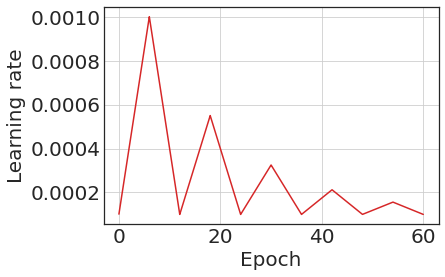

In [291]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1) 
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

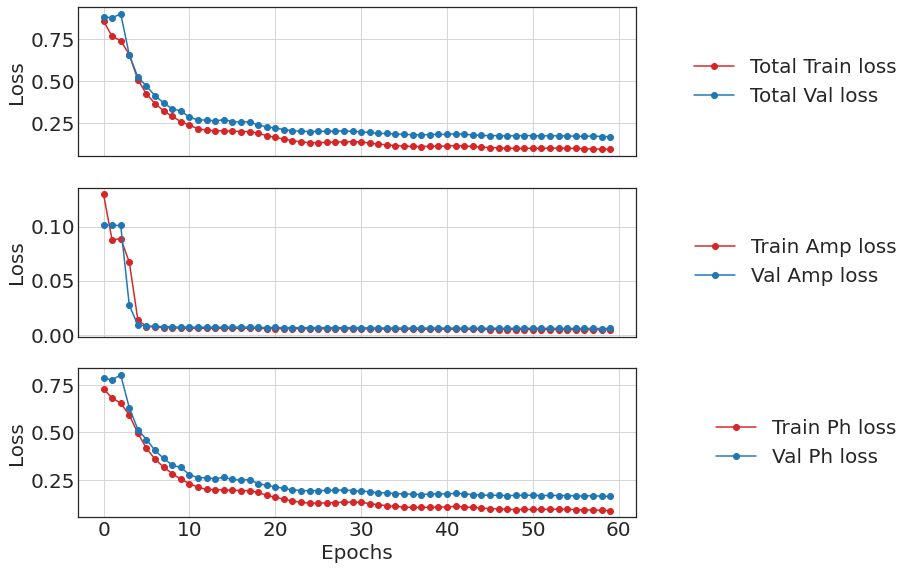

In [292]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [293]:
metrics['val_losses'][-1]

[0.16968205819527307, 0.005902408544595043, 0.16377964864174524]

In [294]:
model.eval() #imp when have dropout etc
amps_eval = []
phs_eval = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp_eval, ph_eval = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps_eval.append(amp_eval[j].detach().to("cpu").numpy())
        phs_eval.append(ph_eval[j].detach().to("cpu").numpy())

In [295]:
amps_eval = np.array(amps_eval).squeeze()
phs_eval = np.array(phs_eval).squeeze()
print(amps_eval.shape, amps_eval.dtype)
print(phs_eval.shape, phs_eval.dtype)

(3600, 64, 64) float16
(3600, 64, 64) float16


<Figure size 432x288 with 0 Axes>

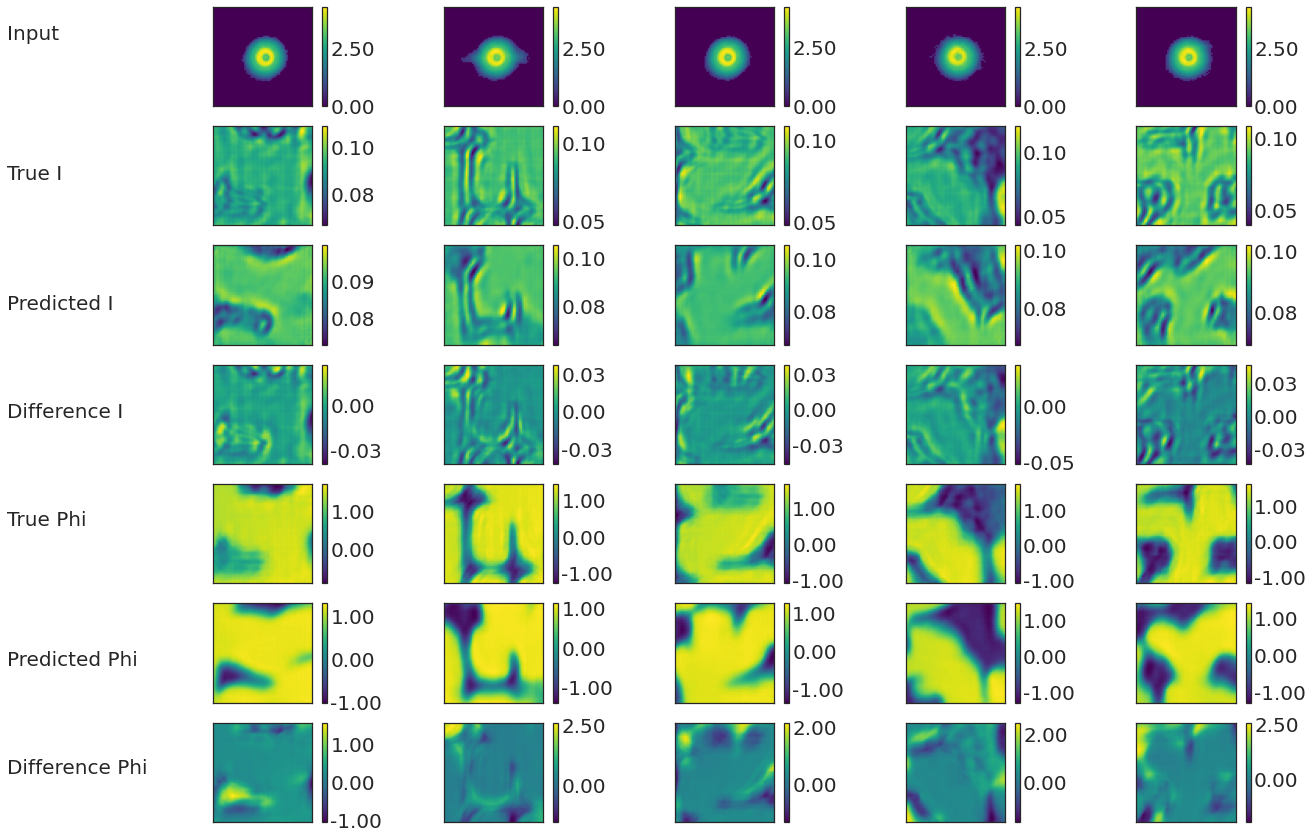

In [296]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [297]:
point_size = 3
overlap = 4*point_size

In [298]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [299]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [300]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [301]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

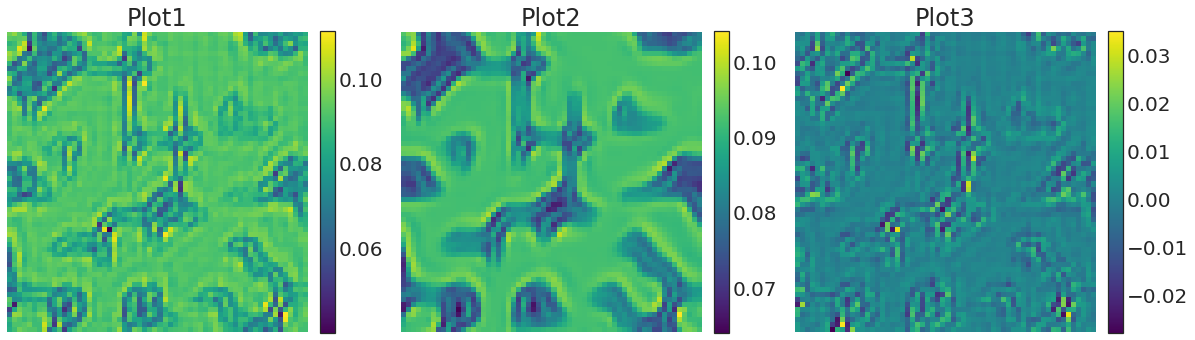

In [302]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

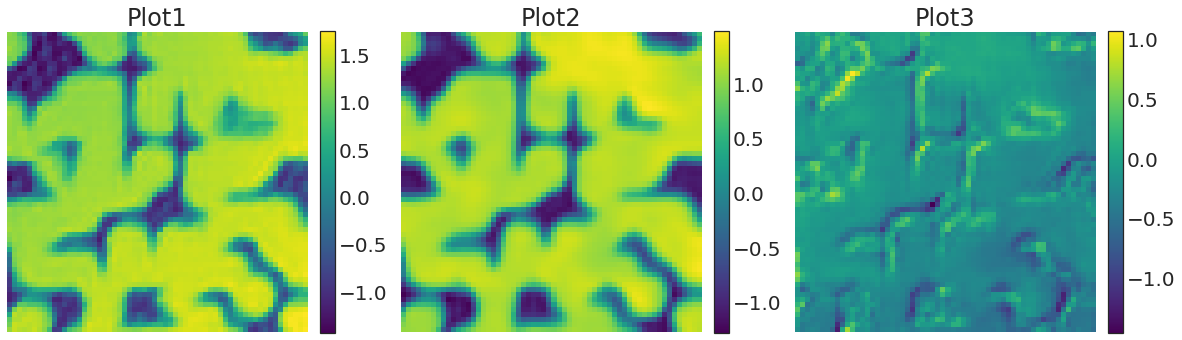

In [303]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [304]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  3.950569468733094e-05
MSE in phase:  0.08969038918025615


In [305]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [306]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.2336594947281659, -1.3685747842145481e-17)